# 이미지 식별 머신을 위한 데이터를 준비


## 라이브러리 import


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms, models

from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = "retina"

## 데이터 디렉토리, 분할 비율, 변환 방법 설정


In [2]:
# Define the data directory and validation size
data_dir = "../data"
valid_size = 0.2

# Define the transformations for the training and validation datasets
t_transforms = transforms.Compose(
    [transforms.RandomResizedCrop(224), transforms.Resize(224), transforms.ToTensor()]
)

print(t_transforms)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 1. 학습 데이터 세트 및 테스트 데이터 세트의 디렉토리 및 변환 방식을 지정


In [3]:
train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
test_data = datasets.ImageFolder(data_dir, transform=t_transforms)

# Split the dataset into training and validation sets
print(train_data)

# Calculate the number of training and validation samples
print(len(train_data), len(test_data))

Dataset ImageFolder
    Number of datapoints: 155
    Root location: ../data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
155 155


## 2. 데이터 세트를 섞기 위해 인덱스를 만들어 셔플


In [4]:
# Create indices for the training data
num_train = len(train_data)
indices = list(range(num_train))
print(indices)

# Shuffle the indices
np.random.shuffle(indices)
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[153, 37, 109, 126, 50, 4, 61, 14, 10, 79, 21, 86, 46, 65, 150, 12, 116, 5, 74, 41, 114, 83, 115, 103, 27, 90, 32, 98, 146, 118, 34, 51, 76, 112, 89, 151, 97, 67, 125, 1, 33, 133, 0, 95, 15, 22, 59, 143, 7, 66, 3, 149, 135, 16, 72, 30, 36, 107, 2, 152, 96, 102, 140, 111, 48, 82, 138, 80, 124, 99, 106, 39, 137, 40, 145, 64, 142, 24, 

## 3. 분할 비율(valid_size)에 따른 지점의 인덱스 값(split) 계산


In [5]:
split = int(np.floor(valid_size * num_train))
print(split)

31


## 4. split을 기준으로 학습 데이터 인덱스 리스트와 테스트 인덱스 리스트로 분할


In [6]:
train_idx, test_idx = indices[split:], indices[:split]

print(train_idx)
print(test_idx)

[51, 76, 112, 89, 151, 97, 67, 125, 1, 33, 133, 0, 95, 15, 22, 59, 143, 7, 66, 3, 149, 135, 16, 72, 30, 36, 107, 2, 152, 96, 102, 140, 111, 48, 82, 138, 80, 124, 99, 106, 39, 137, 40, 145, 64, 142, 24, 25, 77, 52, 29, 91, 136, 87, 19, 104, 134, 129, 154, 18, 13, 9, 122, 58, 69, 17, 144, 94, 57, 47, 139, 54, 38, 49, 44, 108, 71, 100, 75, 56, 8, 11, 85, 53, 117, 31, 101, 43, 88, 132, 26, 6, 23, 130, 131, 63, 78, 70, 55, 62, 20, 105, 60, 123, 148, 84, 81, 127, 92, 113, 121, 73, 45, 35, 119, 128, 28, 110, 147, 68, 93, 120, 141, 42]
[153, 37, 109, 126, 50, 4, 61, 14, 10, 79, 21, 86, 46, 65, 150, 12, 116, 5, 74, 41, 114, 83, 115, 103, 27, 90, 32, 98, 146, 118, 34]


## 5. 데이터 세트들의 샘플러 및 로더를 만들고 확인


In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

# Create samplers for the training and validation datasets
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Create data loaders for the training and validation datasets
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=16, sampler=train_sampler
)

test_loader = torch.utils.data.DataLoader(
    train_data, batch_size=16, sampler=test_sampler
)

# Print the classes in the dataset
print(train_loader.dataset.classes)
print(test_loader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


## load_split_train_test() 함수 선언


In [8]:
def load_split_train_test():
    t_transforms = transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.Resize(224),
            transforms.ToTensor(),
        ]
    )

    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=16, sampler=train_sampler
    )

    test_loader = torch.utils.data.DataLoader(
        train_data, batch_size=16, sampler=test_sampler
    )

    return train_loader, test_loader

## load_split_train_test() 함수를 사용하여 train_loader, test_loader를 생성


In [9]:
train_loader, test_loader = load_split_train_test()

print(train_loader.dataset.classes)
print(test_loader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


# 이미지 데이터 샘플 확인


## 임의의 데이터를 로딩한 후 이미지와 레이블을 반환하는 get_random_image() 함수 선언


In [10]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler

    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, batch_size=num, sampler=sampler)

    data_iterator = iter(loader)
    images, labels = next(data_iterator)

    return images, labels

## 임의 선택한 이미지를 표시


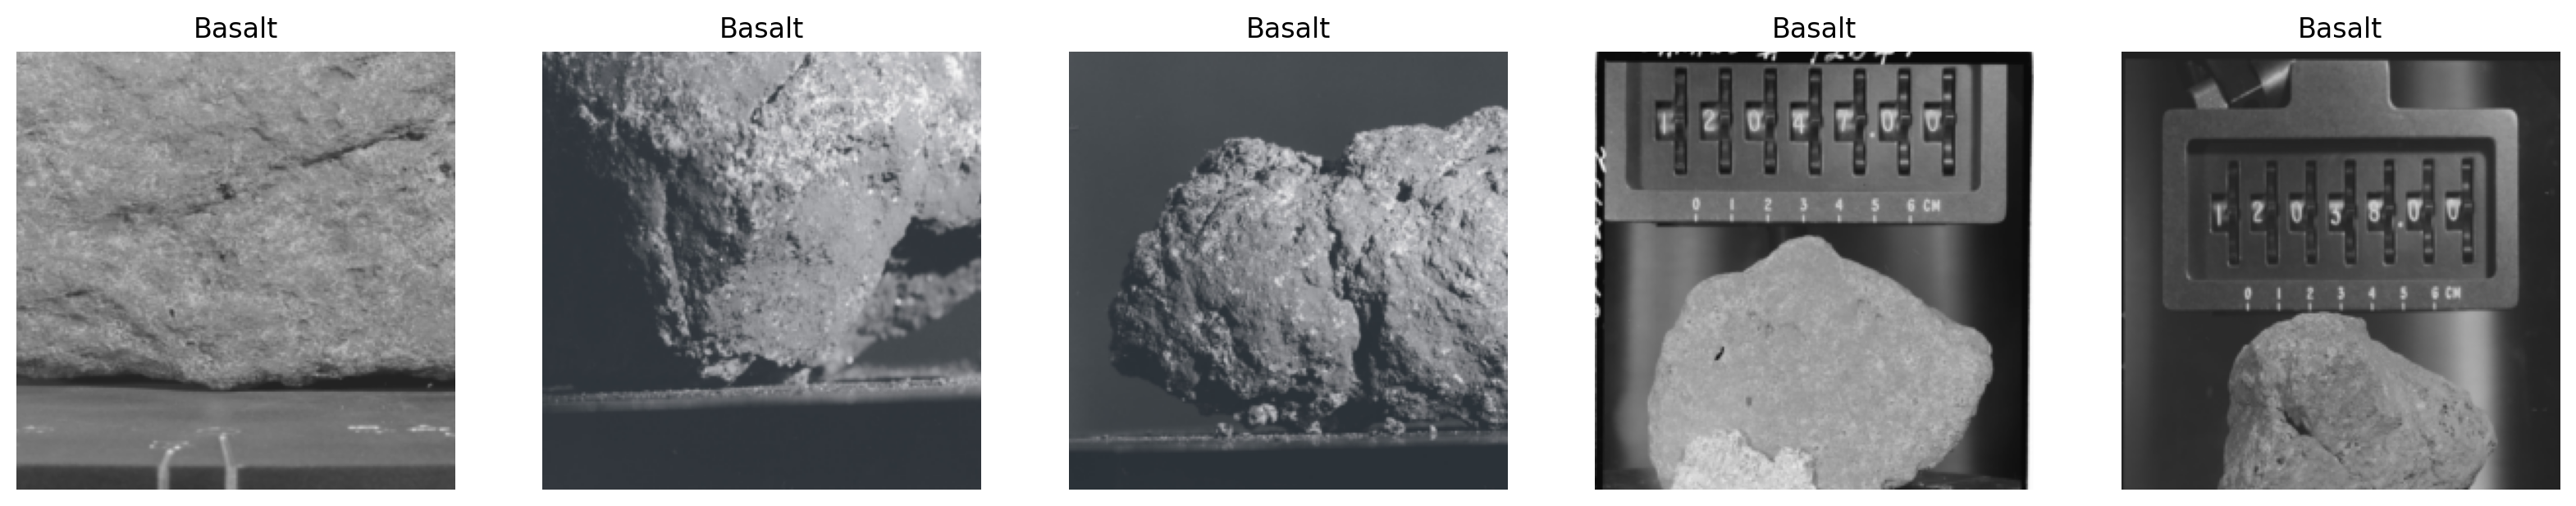

In [11]:
# Get 5 random images and their labels
images, labels = get_random_images(5)

# Convert images to PIL format for visualization
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))

# Display the images with their corresponding labels
classes = train_loader.dataset.classes
for image_index in range(len(images)):
    image = to_pil(images[image_index])
    sub = fig.add_subplot(1, len(images), image_index + 1)
    index = labels[image_index].item()
    sub.set_title(classes[index])
    plt.axis("off")
    plt.imshow(image)

plt.show()

# ResNet50 모델을 로드하여 FCL(Fully Connected Layer) 수정


## Compute device 선택


In [12]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps:0")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


device = get_device()
print(device)

mps:0


## 사전 학습된 ResNet50 모델 지정


In [13]:
model = models.resnet50(pretrained=True)

/Users/j1star/Desktop/MS AI Projects/microsoft-ai-school/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/j1star/Desktop/MS AI Projects/microsoft-ai-school/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Fully Connected Layer (FCL) 수정 (뉴런 구축, 신경망 연결, FCL의 layer 설정 등)


In [14]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 512, device=device),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2, device=device),
    nn.LogSoftmax(dim=1),
)

criterion = nn.NLLLoss()

# optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
optimizer = optim.Adagrad(model.fc.parameters(), lr=0.003)
# optimizer = optim.SGD(model.fc.parameters(), lr=0.003)


model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


# 모델의 FCL 학습 및 테스트


## 모델의 학습 / 검증을 위한 변수를 설정


In [16]:
epochs = 10
print_every = 5

running_loss = 0
train_losses, test_losses = [], []

steps = 0

## 설정한 epoch만큼 모델을 학습시키며 검증 / 평가


In [17]:
for epoch in range(epochs):
    epoch += 1

    for inputs, labels in train_loader:
        steps += 1
        print(f"Train steps: {steps}")

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)

        loss = criterion(logps, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0

            model.eval()

            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    logps = model.forward(inputs)

                    batch_loss = criterion(logps, labels)

                    test_loss += batch_loss.item()

                    ps = torch.exp(logps)

                    top_p, top_class = ps.topk(1, dim=1)

                    equals = top_class == labels.view(*top_class.shape)

                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(test_loader))

            print(
                f"""
                Epoch {epoch} / {epochs}
                Train loss: {running_loss/len(train_loader):.3f}
                Test loss: {test_loss/len(test_loader):.3f}
                Test accuracy: {accuracy/len(test_loader):.3f} 
            """
            )

            running_loss = 0

            model.train()

            break

Train steps: 1
Train steps: 2
Train steps: 3
Train steps: 4
Train steps: 5

                Epoch 1 / 10
                Train loss: 1.281
                Test loss: 0.596
                Test accuracy: 0.679 
            
Train steps: 6
Train steps: 7
Train steps: 8
Train steps: 9
Train steps: 10

                Epoch 2 / 10
                Train loss: 0.366
                Test loss: 0.510
                Test accuracy: 0.710 
            
Train steps: 11
Train steps: 12
Train steps: 13
Train steps: 14
Train steps: 15

                Epoch 3 / 10
                Train loss: 0.349
                Test loss: 0.603
                Test accuracy: 0.710 
            
Train steps: 16
Train steps: 17
Train steps: 18
Train steps: 19
Train steps: 20

                Epoch 4 / 10
                Train loss: 0.263
                Test loss: 0.782
                Test accuracy: 0.513 
            
Train steps: 21
Train steps: 22
Train steps: 23
Train steps: 24
Train steps: 25

                

## 학습 손실값과 테스트 손실값 확인


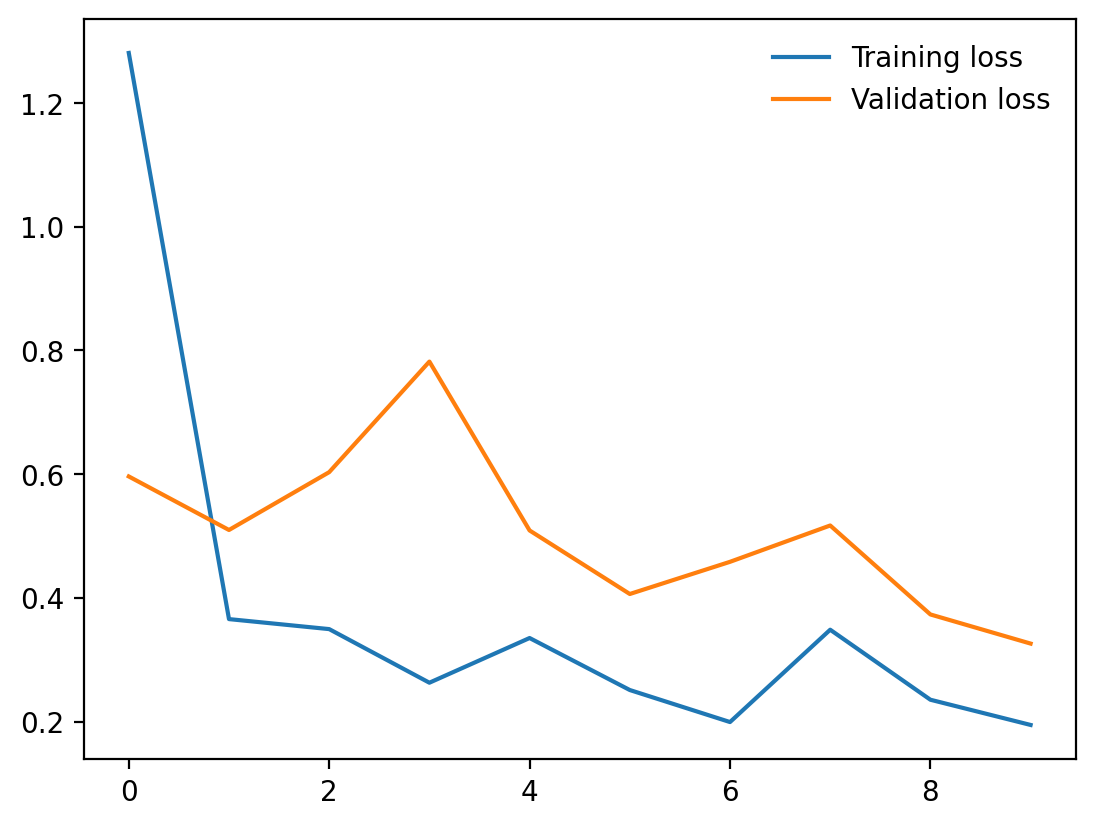

In [18]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.legend(frameon=False)

## 학습 / 테스트 완료된 모델 저장


In [19]:
torch.save(model, "moonrockmodel.pth")

## 모델 불러오기


In [20]:
model = torch.load("moonrockmodel.pth", weights_only=False)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 이미지 예측을 위한 predict_image() 함수 선언


In [27]:
def predict_image(image):
    image_tensor = t_transforms(image).float()

    input = image_tensor.unsqueeze_(0)
    input = input.to(device)

    output = model(input)
    index = output.data.cpu().numpy().argmax()

    return index

## 임의의 5개 이미지를 예측


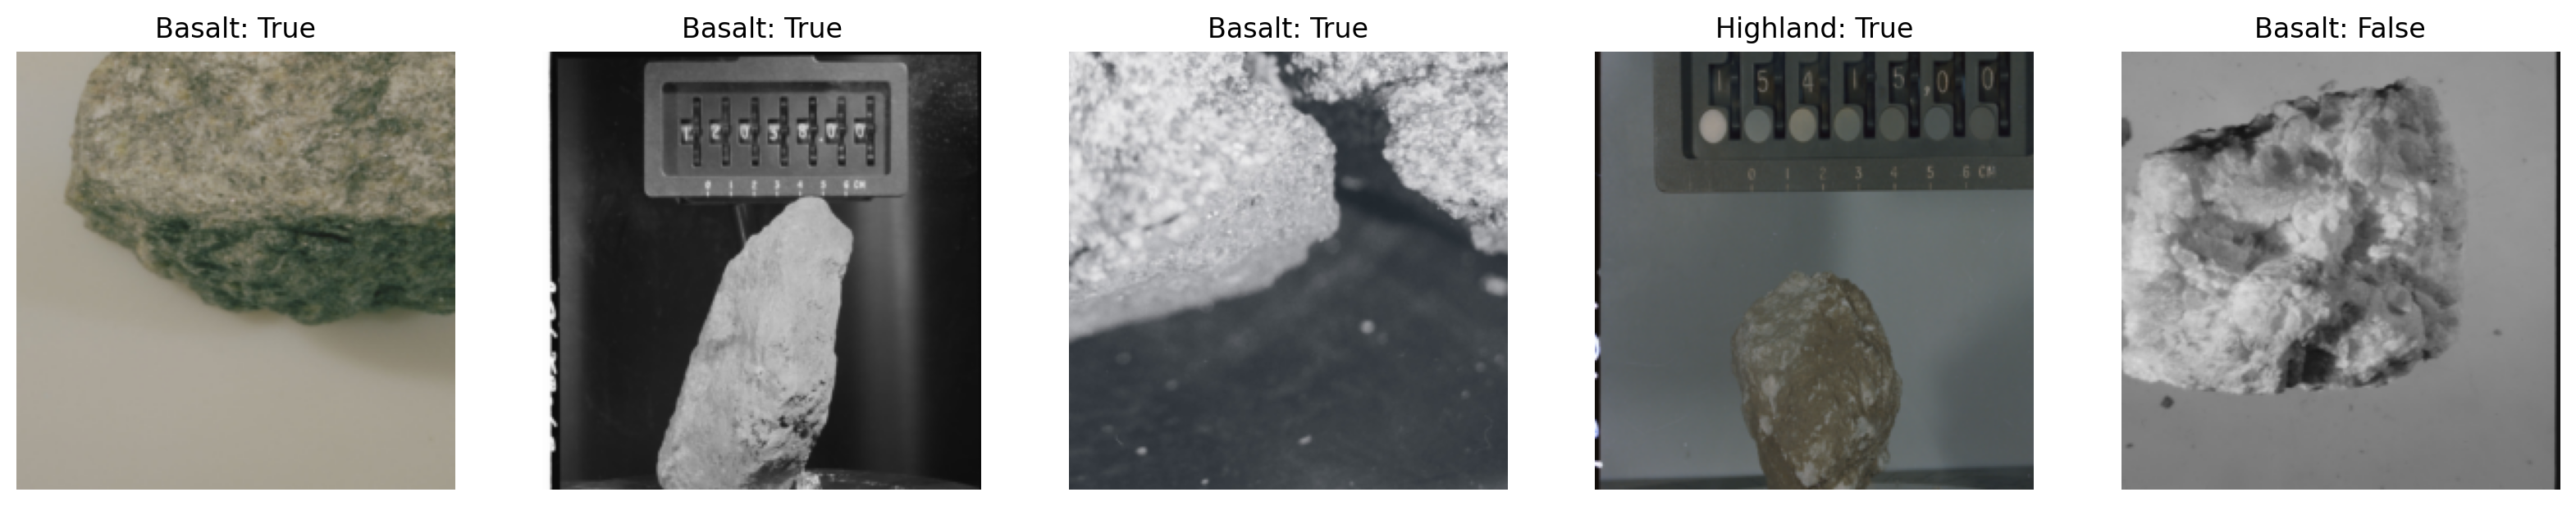

In [37]:
model.eval()

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)

fig = plt.figure(figsize=(20, 20))

classes = train_loader.dataset.classes

for image_index in range(len(images)):
    image = to_pil(images[image_index])
    index = predict_image(image)

    sub = fig.add_subplot(1, len(images), image_index + 1)

    result = labels[image_index].item() == index
    
    sub.set_title(f"{classes[index]}: {result}")
    plt.axis("off")
    plt.imshow(image)

plt.show()